In [1]:
# imports

import itertools
import time

import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import vmap, jit, grad
from jax.experimental import optimizers
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0 as eps_0, mu_0, c, pi
from scipy.interpolate import interp1d
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import trange

In [2]:
# enable 64-bit precision in `jax`

# jax.config.update('jax_enable_x64', True)

In [3]:
# set context to `seaborn`

seaborn.set(context='talk', palette='colorblind', font='sans-serif')

In [4]:
# high-resolution rendering

%config InlineBackend.figure_format = 'retina'

In [5]:
# constants

Z_0 = np.sqrt(mu_0 / eps_0)
a = 2e-3
N_elem = 61
L = 1
dx = L / N_elem
x = np.arange(0, L+dx/2, dx)
I = np.loadtxt('DipolSctGnd025.str')

In [6]:
# load current over a half-wave dipole antenna for 3 GHz frequency

f = I[N_elem+1:, 1][0]
omega = 2 * pi * f
k = omega * np.sqrt(mu_0 * eps_0)
I_an = I[N_elem+1:, 2] + 1j * I[N_elem+1:, 3]

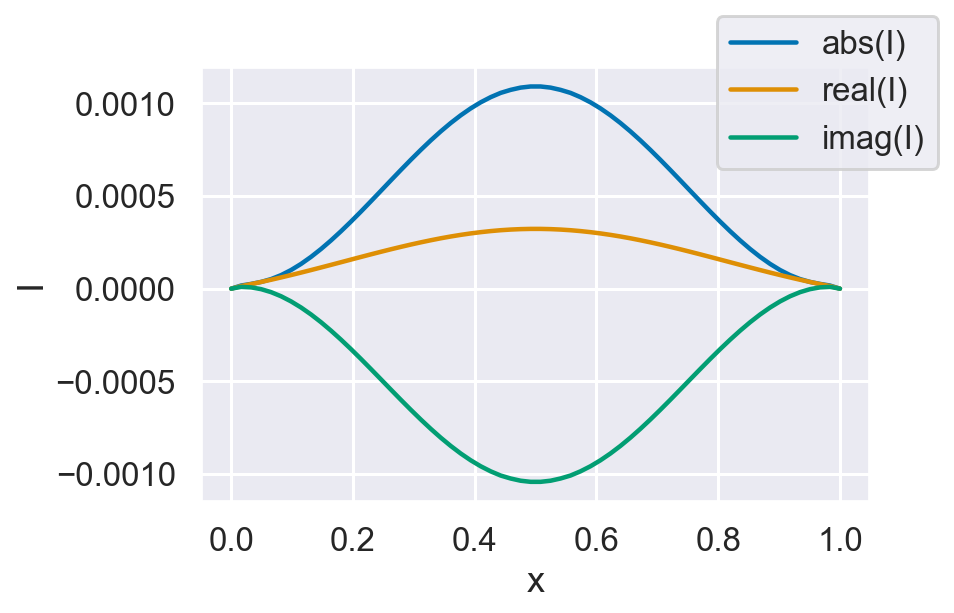

In [7]:
# visualize spatial current distribution

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x, np.abs(I_an), label='abs(I)')
ax.plot(x, np.real(I_an), label='real(I)')
ax.plot(x, np.imag(I_an), label='imag(I)')
ax.set(xlabel='x', ylabel='I')
fig.legend();

# Finite-step derivative approximation on interpolated function

In [8]:
def forward_diff(fn, h=1e-6):
    """Forward difference approximation."""
    def dfn_dx(x):
        return (fn(x + h) - fn(x)) / h
    return dfn_dx
    
    
def backward_diff(fn, h=1e-6):
    """Backward difference approximation."""
    def dfn_dx(x):
        return (fn(x) - fn(x - h)) / h
    return dfn_dx

    
def central_diff(fn, h=1e-6):
    """Central difference approximation."""
    def dfn_dx(x):
        return (fn(x + h) - fn(x - h)) / (2 * h)
    return dfn_dx


def complex_step_diff(fn, h=1e-6):
    """Complex-step difference approximation.
    
    Note: Incompatible with SciPy interpolation module.
    """
    def dfn_dx(x):
        return np.imag(fn(x + 1j * h)) / h
    return dfn_dx

In [9]:
# quadratic interpolation of current distribution function
y = np.abs(I_an) * 1000
f = interp1d(x, y, kind='quadratic')

x_new = np.linspace(x.min(), x.max(), 1001)
y_new = f(x_new)

In [10]:
# mean relative percentage error

error = np.mean(np.abs(y[1:-1] - f(x)[1:-1]) / y[1:-1]) * 100
print(f'relative error = {error:.2e} %')

relative error = 5.61e-15 %


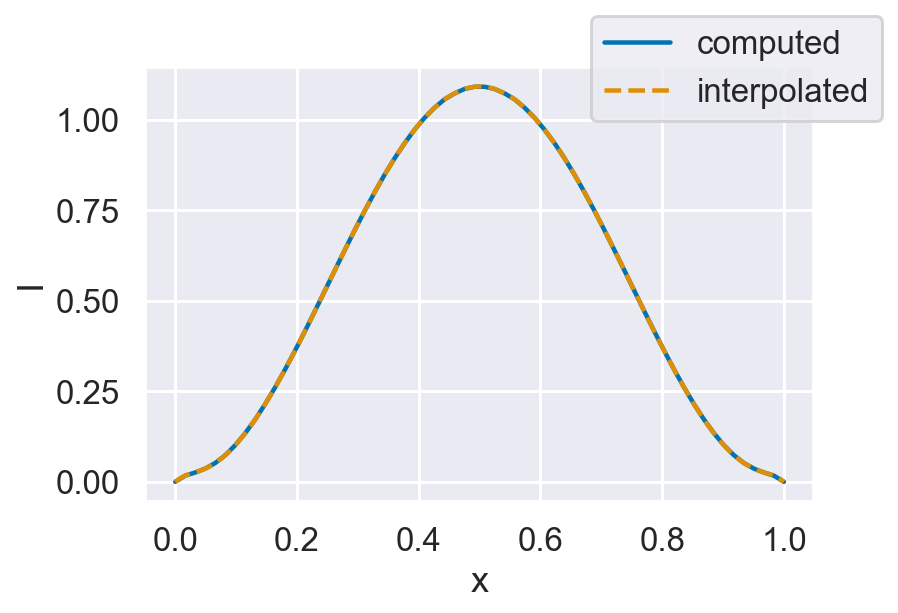

In [11]:
# visualize spatial current distribution as calculated and interpolated

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x, y, label='computed')
ax.plot(x_new, y_new, '--', label='interpolated')
ax.set(xlabel='x', ylabel='I')
fig.legend();

In [12]:
# finite difference on computed and interpolated data

dfdx = np.r_[(forward_diff(f)(x[0]), central_diff(f)(x[1:-1]), backward_diff(f)(x[-1]))]
dfdx_new = np.r_[(forward_diff(f)(x_new[0]), central_diff(f)(x_new[1:-1]), backward_diff(f)(x_new[-1]))]

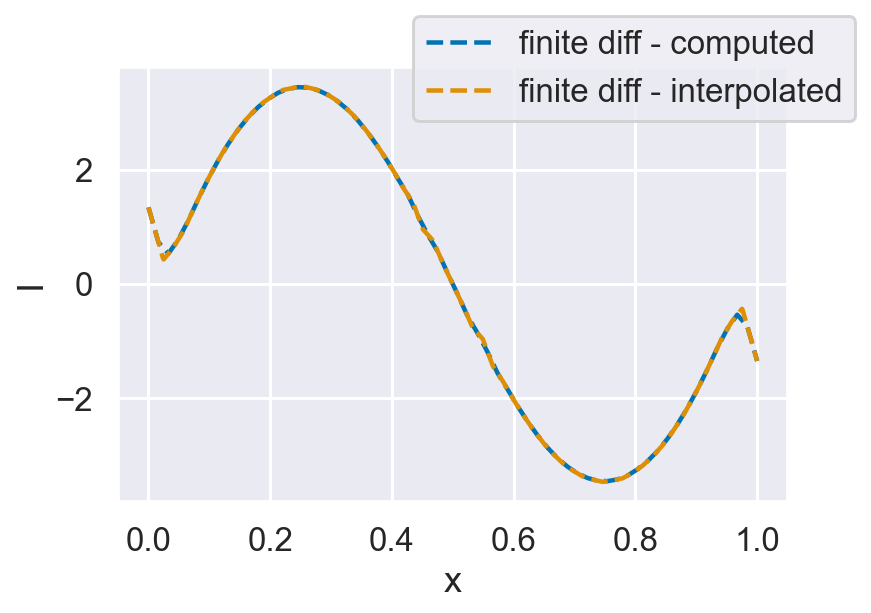

In [13]:
# visualize current gradient distribution as calculated and interpolated

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x, dfdx, '--', label='finite diff - computed')
ax.plot(x_new, dfdx_new, '--', label='finite diff - interpolated')
ax.set(xlabel='x', ylabel='I')
fig.legend();

# Automatic differentiation on neural network-based interpolation

In [14]:
x_train = jnp.asarray(x_new).reshape(-1, 1)
y_train = jnp.asarray(y_new).reshape(-1, 1)

In [15]:
rng = jax.random.PRNGKey(0)

def init_network_params(sizes, key):
    """Initialize network parameters."""
    keys = jax.random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = jax.random.split(key)
        return (scale * jax.random.normal(w_key, (n, m)),
                scale * jax.random.normal(b_key, (n, )))
    return [random_layer_params(m, n, key)
            for m, n, key in zip(sizes[:-1], sizes[1:], keys)]


def forward(params, X):
    """Forward pass."""
    output = X
    for w, b in params[:-1]:
        output = nn.tanh(w @ output + b)
    w, b = params[-1]
    output = w @ output + b
    return output


# vectorized mapping of network input, `X`, on `forward` function
batch_forward = vmap(forward, in_axes=(None, 0))


@jit
def loss_fn(params, batch):
    """Summed square error loss function."""
    X, y = batch
    y_pred = batch_forward(params, X)
    return jnp.sum(jnp.square(y_pred - y))


# derivative of the loss function
grad_fn = jit(grad(loss_fn))


@jit
def update(step, optim_state, batch):
    """Return current optimal state of the network."""
    params = optim_params(optim_state)
    grads = grad_fn(params, batch)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state


def data_stream(num_train, num_batches):
    """Training data random generator."""
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield x_train[batch_idx], y_train[batch_idx]

In [17]:
# set network hyperparameter and train

step_size = 1e-3
n_epochs = 50000
printout = int(n_epochs / 10.)
batch_size = 64
momentum_mass = 0.9  # for momentum and adagrad
sizes = [1, 128, 128, 128, 1]

num_train = x_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

batches = data_stream(num_train, num_batches)

optim_init, optim_update, optim_params = optimizers.adam(step_size)
init_params = init_network_params(sizes, rng)
optim_state = optim_init(init_params)
itercount = itertools.count()

loss_train = []
for epoch in trange(n_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        optim_state = update(next(itercount), optim_state, next(batches))
    epoch_time = time.time() - start_time
    
    params = optim_params(optim_state)
    if (epoch == 0) or (epoch % printout == (printout - 1)):
        loss_train.append(loss_fn(params, (x_train, y_train)))

  0%|          | 0/50000 [00:00<?, ?it/s]

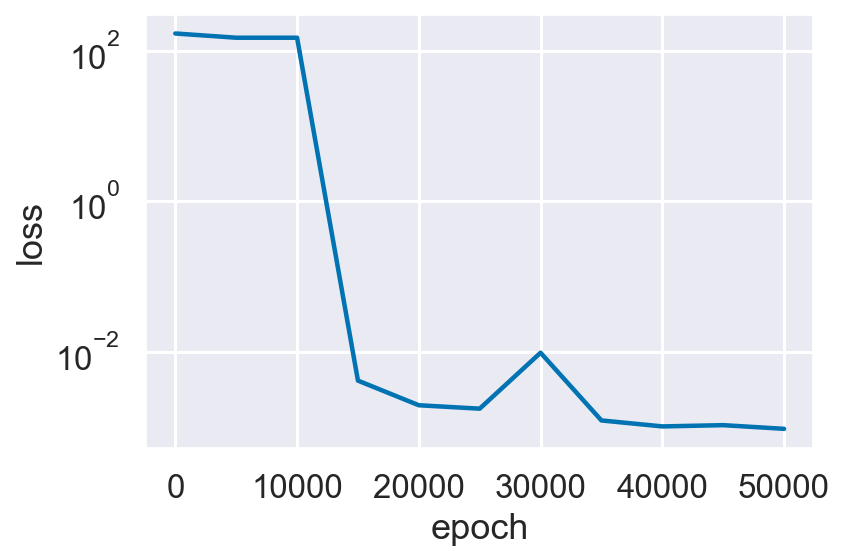

In [18]:
# visualize training loss dynamics

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(0, n_epochs+1, step=printout), loss_train)
ax.set(xlabel='epoch', ylabel='loss', yscale='log');

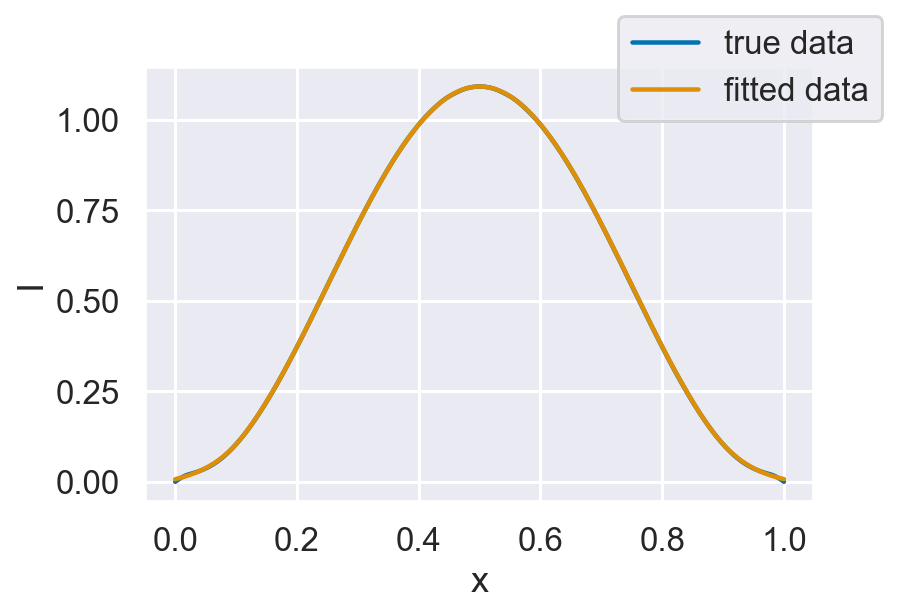

In [19]:
# visualize spatial current distribution as calculated and fitted

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_train.flatten(), y_train.flatten(), label='true data')
ax.plot(x_train.flatten(), batch_forward(params, x_train).flatten(), label='fitted data')
ax.set(xlabel='x', ylabel='I')
fig.legend();

In [20]:
def I_an_nn(x):
    """Current value at specific location, `x`.
    
    Note: This is single-value wrapper for the forward pass function.
    """
    return forward(params, x)[0]


# derivative of the current approximation function
grad_I_an_nn = jit(vmap(grad(I_an_nn)))

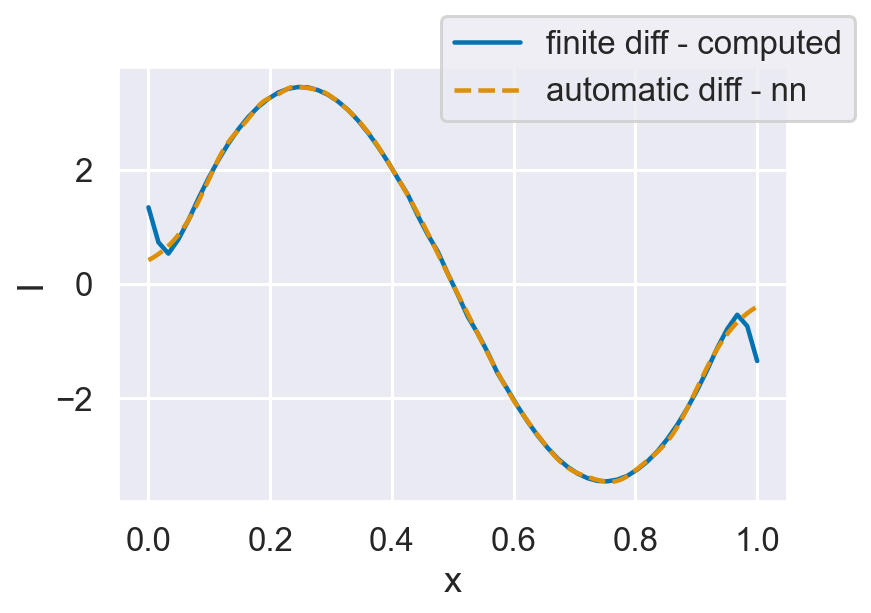

In [21]:
# visualize current gradient distribution as calculated and fitted

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x, np.r_[(forward_diff(f)(x[0]), central_diff(f)(x[1:-1]), backward_diff(f)(x[-1]))], '-', label='finite diff - computed')
ax.plot(x_train, grad_I_an_nn(x_train), '--', label='automatic diff - nn')
ax.set(xlabel='x', ylabel='I')
fig.legend();

# Power distribution

In [23]:
# compute power distribution along the dipole

q_points, q_weights = np.polynomial.legendre.leggauss(4)
q_points_scaled = dx / 2 * q_points + dx / 2
N1 = (1 - q_points) / 2
N2 = (1 + q_points) / 2

dIdx = grad_I_an_nn(jnp.array(x).reshape(-1, 1)).flatten()
V = np.zeros_like(dIdx)
for i in range(N_elem):
    xx = x[i] + q_points_scaled
    dI = dIdx[i] * N1 + dIdx[i+1] * N2
    rad = np.sqrt((x - xx[0]) ** 2 + a ** 2)
    G = dI[0] * q_weights[0] * np.exp(-1j * k * rad) / rad
    rad = np.sqrt((x - xx[1]) ** 2 + a ** 2)
    G = G + dI[1] * q_weights[1] * np.exp(-1j * k * rad) / rad
    rad = np.sqrt((x - xx[2]) ** 2 + a ** 2)
    G = G + dI[2] * q_weights[2] * np.exp(-1j * k * rad) / rad
    rad = np.sqrt((x - xx[3]) ** 2 + a ** 2)
    G = G + dI[3] * q_weights[3] * np.exp(-1j * k * rad) / rad
    V = V + G
V = 0.5 * dx * V / (-1j * 4 * pi * omega * eps_0)

S = 0.5 * V * np.conj(I_an)
P = np.real(S)
Q = np.imag(S)

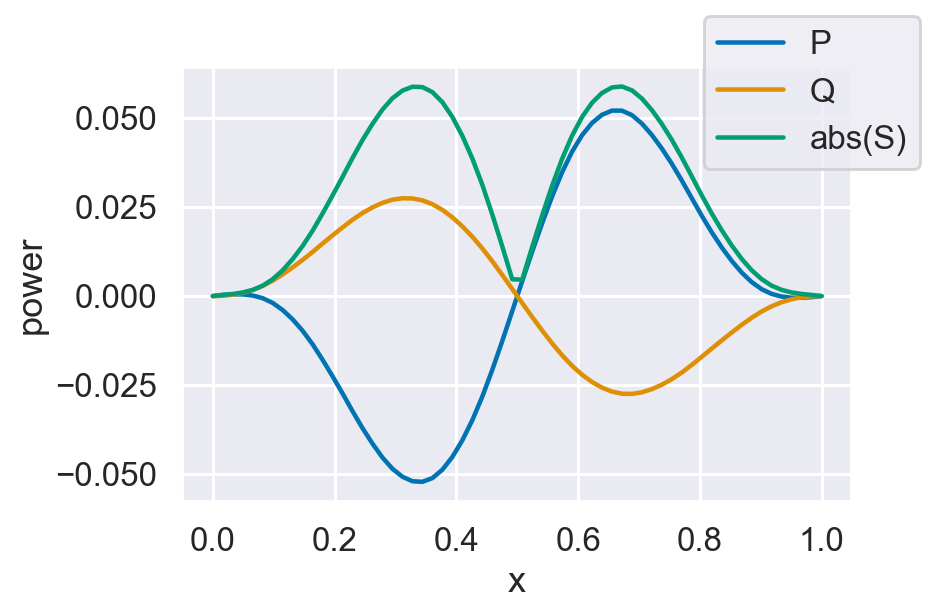

In [24]:
# visualize power spatial distribution

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x, P, label='P')
ax.plot(x, Q, label='Q')
ax.plot(x, np.abs(S), label='abs(S)')
ax.set(xlabel='x', ylabel='power')
fig.legend();